Import libraries

In [1]:
from typing import Counter
import numpy as np
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline
from imblearn.metrics import classification_report_imbalanced

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

Input

In [2]:
df=pd.read_csv("resistance_data_20172021-v5.csv",delimiter=",",index_col=0)
df['AGE']=2022-df['AGE']
labelencoder = LabelEncoder()
encoder = OneHotEncoder(handle_unknown='ignore')
sc = StandardScaler()
c = 1000
over = SMOTE(random_state=42,sampling_strategy=0.5)
under = RandomUnderSampler(random_state=42,sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

Plot (PRC and ROC)

In [3]:
def PRCplot(clf,y_score,y_probs,y_test,sampling,model_name):
    precision=0
    recall=0
    thresholds=0
    #PRC_Recall CURVE
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    display_PRC = PrecisionRecallDisplay.from_predictions(y_test, y_probs, name=model_name+sampling)
    #precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    #display_PRC = PrecisionRecallDisplay.from_predictions(y_test, y_score, name=model_name)
    ns=np.sum(y_test) #số giá trị R/tập test
    n=len(y_test) #số lượng y_test
    plt.plot([0, 1], [ns/n,ns/n], linestyle = '--')
    plt.xlabel('Recall', fontsize = 12)
    plt.ylabel('Precision', fontsize = 12)
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    plt.ylim(bottom=0)
    plt.xlim(0,1)
    plt.show()
    auc_precision_recall = auc(recall, precision)
    print('AUC_PRC : %.2f' %auc_precision_recall)
    return precision, recall

def ROCplot(clf,y_score,y_probs,y_test,sampling,model_name):

    fpr, tpr, _ = (0,0,0)
    fpr, tpr, _ = roc_curve(y_test, y_probs, pos_label=clf.classes_[1])
    #fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=0)
    roc_auc = metrics.auc(fpr, tpr)
    display_ROC = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name=model_name+sampling)
    display_ROC.plot()
    plt.xlabel('False Positive Rate',fontsize = 12)
    plt.ylabel('True Positive Rate',fontsize = 12)
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    
    plt.show()
    print('AUC_ROC : %.2f' % roc_auc)

Retrieve data

In [4]:
def GetDataNoGroup(ANname):
    temp=df[df[ANname].isin([1,0])]
    df_1=df[df[ANname].isin([1,0])]
    if (df_1.shape[0] <= 50):
        clean_X=np.array
        clean_Y=np.array
        return clean_X,clean_Y
    #X_cat=df_1.iloc[:,[9,12,23]]
    #2,9,12,23: GENDER, WARD, DIAGNOSIS, SAMPLE
    #3, 13-21: AGE,OTHER INF -> INDWELLING
    x_num=df_1.iloc[:,[3,13,14,15,16,17,18,19,20,21,22]]
    x_cat=df_1.iloc[:,[2,9,12,23,25]]
    Y=df_1[ANname]
    encoder_df = encoder.fit_transform(x_cat).toarray()
    clean_X=np.array(x_num)
    clean_X=np.concatenate((clean_X,encoder_df),axis=1)

    clean_Y=np.array(Y)
    return clean_X,clean_Y

Stratified sampling (Train test split)

In [5]:
def StratSampling(clean_X,clean_Y):
    x_train, x_test, y_train, y_test = train_test_split(clean_X, clean_Y, test_size=0.2, random_state=42,stratify=clean_Y)
    x_train_std = sc.fit_transform(x_train)
    x_test_std = sc.transform(x_test)
    return x_train_std,x_test_std,y_train,y_test

def Datasampling(method,x,y):
    x_resampled=0
    y_resampled=0
    if (method=="over"):
        x_resampled, y_resampled = RandomOverSampler(random_state=42).fit_resample(x, y)
    elif (method=="under"):
        x_resampled, y_resampled = RandomUnderSampler(random_state=42).fit_resample(x, y)
    elif (method=="SMOTE"):
        x_resampled, y_resampled = SMOTE(random_state=42).fit_resample(x,y)
    elif (method=="SMOTEunder"):
        x_resampled, y_resampled = pipeline.fit_resample(x, y)
    else:
        x_resampled=x
        y_resampled=y
    return x_resampled, y_resampled 

Training section

In [6]:
def Train(x_train_std,x_test_std,y_train,y_test):
    sampling=['SMOTEunder']
    for sampling in sampling_method:
        print(sampling+' sampling')
        if ((sampling=='under') and (len(y_train)-np.sum(y_train)<=50)):
            print('Too few sensitive data to implement undersampling') 
            continue
        if (len(y_train)<50):
            print('Not engough data <100')
            continue
        plt.clf()
        for model in model_name:
            print(sampling + ' ' +model)
            x_sampling=np.array
            y_sampling=np.array
            x_sampling, y_sampling=Datasampling(sampling,x_train_std,y_train)
            print(Counter(y_sampling))
            clf = 0
            #--------models----------
            if model == 'Logistic Regression ':
                clf = LogisticRegression(penalty='l1', C=c, max_iter = 5000 ,multi_class='ovr',solver='saga',random_state=42)
            elif model == 'SVM ':
                #clf = svm.SVC(kernel='rbf',C=c,decision_function_shape='ovr',random_state=42,max_iter = 5000,probability=True)
                clf = svm.SVC(kernel='rbf',C=c,decision_function_shape='ovr',random_state=42,probability=True)
            elif model == 'Decision Tree ':
                clf = DecisionTreeClassifier(random_state=42,min_samples_leaf=5)
                #,
            elif model == 'Random Forest ':
                clf = RandomForestClassifier(n_estimators=100, min_samples_leaf=25,random_state=42)
            elif model == 'XGBoost ':
                #clf = XGBClassifier(num_class=1,n_estimators=100,learning_rate= 0.3, max_depth=6, subsample=1, gamma=0, reg_lambda=1, max_delta_step=0,colsample_bytree=1, 
                                    #min_child_weight=1, seed=1000, eval_metric='mlogloss')
                clf = XGBClassifier(num_class=1,n_estimators=100, subsample=1, 
                                    min_child_weight=1, seed=1000)                    
            
            clf.fit(x_sampling, y_sampling)
            #scores = cross_val_score(clf, x_sampling, y_sampling, cv=10, scoring='f1_macro') #cross-validation
            #print('cross-validation :' ,scores)
            #print('cross-validation mean: %.2f' % scores.mean())
            y_score = clf.predict(x_test_std)
            y_probs = clf.predict_proba(x_test_std)[:,1]
            """print('Training accuracy: %.2f' % clf.score(x_sampling, y_sampling)) # Training accuracy
            print('Test accuracy: %.2f' % clf.score(x_test_std, y_test)) # Test accuracy
            print('Precision: ', precision_score(y_test, y_score, average='macro'))
            print('Recall: ', recall_score(y_test, y_score, average='macro'))
            print('MCC: %2f' % matthews_corrcoef(y_test, y_score))"""
            PRCplot(clf,y_score,y_probs,y_test,sampling,model)
            #ROCplot(clf,y_score,y_probs,y_test,sampling,model)
            fpr, tpr, _ = metrics.roc_curve(y_test, y_probs)
            auc = round(metrics.roc_auc_score(y_test, y_probs), 4)
            #plt.plot(fpr,tpr,label=sampling + " " + model + " AUC="+str(auc))
            print('AUC_ROC : %.2f' % roc_auc_score(y_test,y_probs))
            target_names = ['Sensitive','Resistant']
            print(classification_report_imbalanced(y_test, y_score,target_names=target_names))
        #plt.legend()
        #plt.show()
        





Main section

>>>>>>>CEFTAZIDIME<<<<<<<
Counter({1.0: 11828, 0.0: 1976})
SMOTEunder sampling
SMOTEunder Logistic Regression 
Counter({1.0: 11828, 0.0: 5914})


<Figure size 432x288 with 0 Axes>

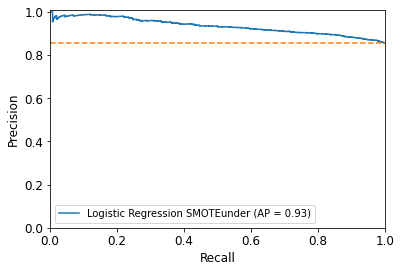

AUC_PRC : 0.93
AUC_ROC : 0.71
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.31      0.35      0.87      0.33      0.55      0.29       494
  Resistant       0.89      0.87      0.35      0.88      0.55      0.32      2957

avg / total       0.81      0.80      0.42      0.80      0.55      0.32      3451

SMOTEunder Decision Tree 
Counter({1.0: 11828, 0.0: 5914})


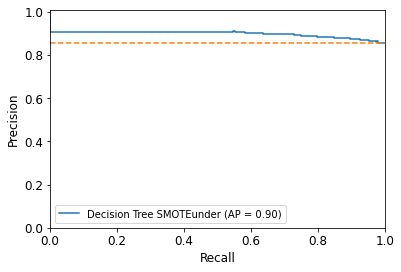

AUC_PRC : 0.92
AUC_ROC : 0.64
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.26      0.31      0.85      0.28      0.51      0.25       494
  Resistant       0.88      0.85      0.31      0.87      0.51      0.28      2957

avg / total       0.79      0.78      0.39      0.78      0.51      0.27      3451

SMOTEunder Random Forest 
Counter({1.0: 11828, 0.0: 5914})


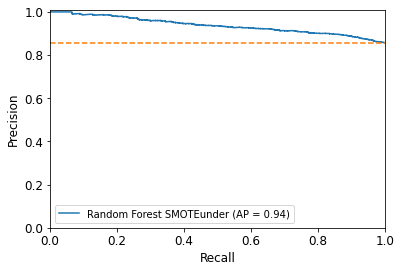

AUC_PRC : 0.94
AUC_ROC : 0.72
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.34      0.21      0.93      0.26      0.44      0.18       494
  Resistant       0.88      0.93      0.21      0.90      0.44      0.21      2957

avg / total       0.80      0.83      0.31      0.81      0.44      0.21      3451

SMOTEunder XGBoost 
Counter({1.0: 11828, 0.0: 5914})


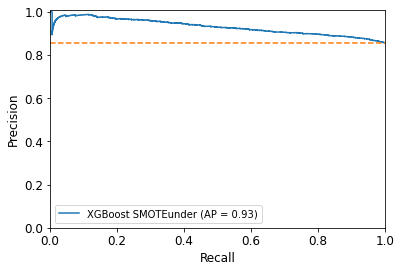

AUC_PRC : 0.93
AUC_ROC : 0.70
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.37      0.14      0.96      0.20      0.37      0.12       494
  Resistant       0.87      0.96      0.14      0.91      0.37      0.15      2957

avg / total       0.80      0.84      0.26      0.81      0.37      0.14      3451

SMOTE sampling
SMOTE Logistic Regression 
Counter({1.0: 11828, 0.0: 11828})


<Figure size 432x288 with 0 Axes>

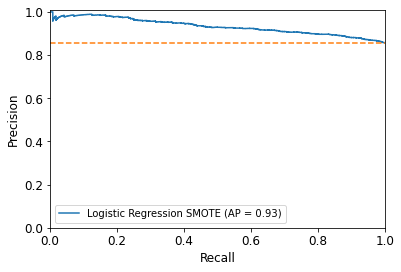

AUC_PRC : 0.93
AUC_ROC : 0.71
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.22      0.71      0.59      0.34      0.64      0.42       494
  Resistant       0.92      0.59      0.71      0.72      0.64      0.41      2957

avg / total       0.82      0.60      0.69      0.66      0.64      0.41      3451

SMOTE Decision Tree 
Counter({1.0: 11828, 0.0: 11828})


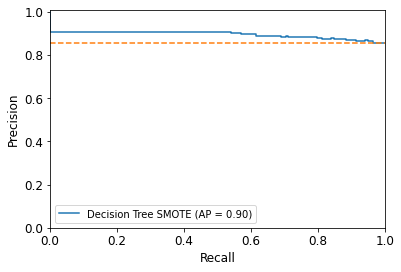

AUC_PRC : 0.92
AUC_ROC : 0.62
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.23      0.33      0.81      0.27      0.52      0.25       494
  Resistant       0.88      0.81      0.33      0.84      0.52      0.28      2957

avg / total       0.79      0.74      0.40      0.76      0.52      0.28      3451

SMOTE Random Forest 
Counter({1.0: 11828, 0.0: 11828})


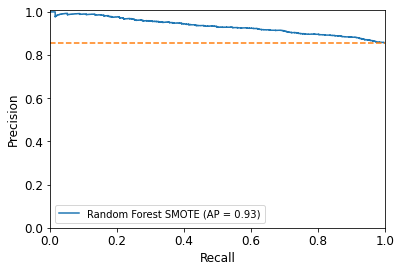

AUC_PRC : 0.93
AUC_ROC : 0.71
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.25      0.53      0.74      0.34      0.62      0.38       494
  Resistant       0.90      0.74      0.53      0.81      0.62      0.40      2957

avg / total       0.81      0.71      0.56      0.74      0.62      0.40      3451

SMOTE XGBoost 
Counter({1.0: 11828, 0.0: 11828})


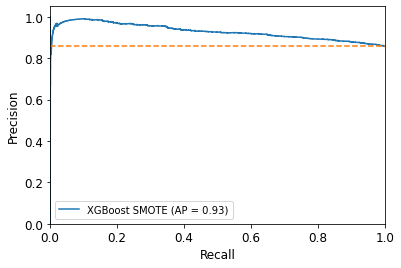

AUC_PRC : 0.93
AUC_ROC : 0.69
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.32      0.19      0.93      0.24      0.42      0.16       494
  Resistant       0.87      0.93      0.19      0.90      0.42      0.19      2957

avg / total       0.79      0.83      0.29      0.81      0.42      0.18      3451

normal sampling
normal Logistic Regression 
Counter({1.0: 11828, 0.0: 1976})


<Figure size 432x288 with 0 Axes>

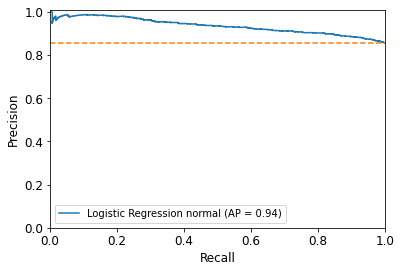

AUC_PRC : 0.94
AUC_ROC : 0.72
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.50      0.01      1.00      0.02      0.09      0.01       494
  Resistant       0.86      1.00      0.01      0.92      0.09      0.01      2957

avg / total       0.81      0.86      0.15      0.79      0.09      0.01      3451

normal Decision Tree 
Counter({1.0: 11828, 0.0: 1976})


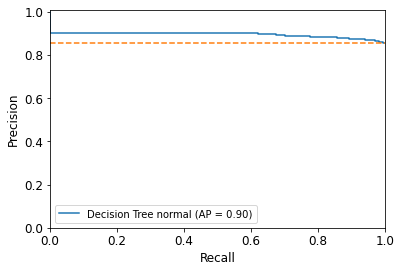

AUC_PRC : 0.92
AUC_ROC : 0.63
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.28      0.21      0.91      0.24      0.44      0.18       494
  Resistant       0.87      0.91      0.21      0.89      0.44      0.21      2957

avg / total       0.79      0.81      0.31      0.80      0.44      0.20      3451

normal Random Forest 
Counter({1.0: 11828, 0.0: 1976})


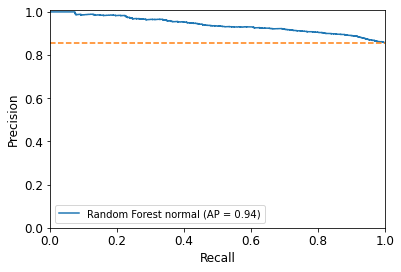

AUC_PRC : 0.94
AUC_ROC : 0.73
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.00      0.00      1.00      0.00      0.00      0.00       494
  Resistant       0.86      1.00      0.00      0.92      0.00      0.00      2957

avg / total       0.73      0.86      0.14      0.79      0.00      0.00      3451

normal XGBoost 
Counter({1.0: 11828, 0.0: 1976})


d:\Anaconda\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


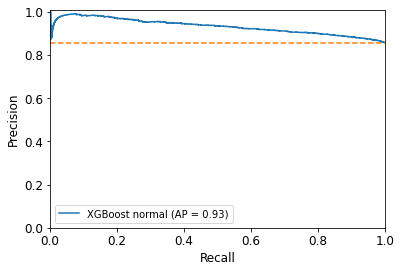

AUC_PRC : 0.93
AUC_ROC : 0.71
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.44      0.11      0.98      0.18      0.33      0.10       494
  Resistant       0.87      0.98      0.11      0.92      0.33      0.12      2957

avg / total       0.81      0.85      0.24      0.81      0.33      0.12      3451

over sampling
over Logistic Regression 
Counter({1.0: 11828, 0.0: 11828})


<Figure size 432x288 with 0 Axes>

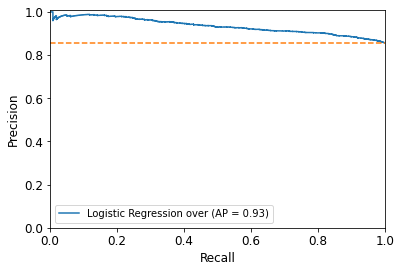

AUC_PRC : 0.93
AUC_ROC : 0.71
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.22      0.70      0.59      0.34      0.64      0.42       494
  Resistant       0.92      0.59      0.70      0.72      0.64      0.41      2957

avg / total       0.82      0.61      0.69      0.66      0.64      0.41      3451

over Decision Tree 
Counter({1.0: 11828, 0.0: 11828})


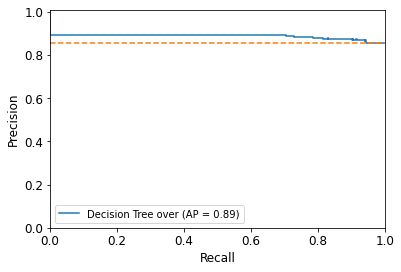

AUC_PRC : 0.92
AUC_ROC : 0.60
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.21      0.40      0.75      0.28      0.55      0.29       494
  Resistant       0.88      0.75      0.40      0.81      0.55      0.31      2957

avg / total       0.79      0.70      0.45      0.73      0.55      0.31      3451

over Random Forest 
Counter({1.0: 11828, 0.0: 11828})


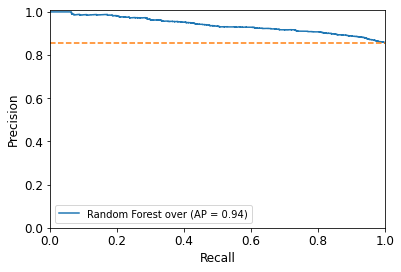

AUC_PRC : 0.94
AUC_ROC : 0.73
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.25      0.67      0.66      0.36      0.66      0.44       494
  Resistant       0.92      0.66      0.67      0.77      0.66      0.44      2957

avg / total       0.83      0.66      0.67      0.71      0.66      0.44      3451

over XGBoost 
Counter({1.0: 11828, 0.0: 11828})


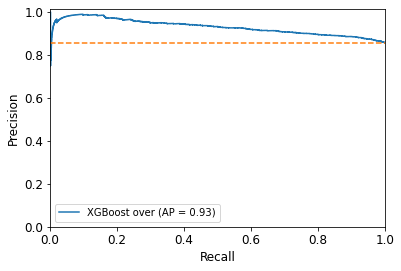

AUC_PRC : 0.93
AUC_ROC : 0.70
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.25      0.54      0.73      0.34      0.63      0.39       494
  Resistant       0.90      0.73      0.54      0.81      0.63      0.40      2957

avg / total       0.81      0.70      0.57      0.74      0.63      0.40      3451

under sampling
under Logistic Regression 
Counter({0.0: 1976, 1.0: 1976})


<Figure size 432x288 with 0 Axes>

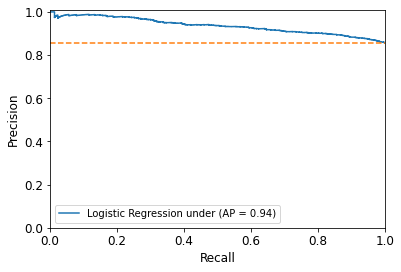

AUC_PRC : 0.94
AUC_ROC : 0.72
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.23      0.74      0.58      0.35      0.65      0.43       494
  Resistant       0.93      0.58      0.74      0.71      0.65      0.42      2957

avg / total       0.83      0.60      0.72      0.66      0.65      0.42      3451

under Decision Tree 
Counter({0.0: 1976, 1.0: 1976})


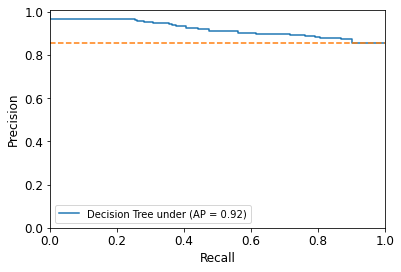

AUC_PRC : 0.93
AUC_ROC : 0.67
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.20      0.67      0.56      0.31      0.61      0.38       494
  Resistant       0.91      0.56      0.67      0.69      0.61      0.37      2957

avg / total       0.81      0.58      0.65      0.64      0.61      0.37      3451

under Random Forest 
Counter({0.0: 1976, 1.0: 1976})


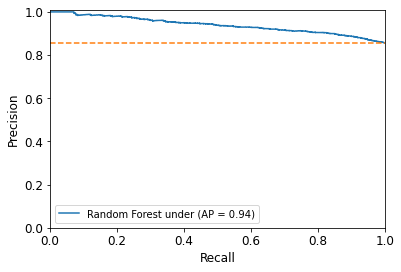

AUC_PRC : 0.94
AUC_ROC : 0.73
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.24      0.71      0.61      0.36      0.66      0.44       494
  Resistant       0.93      0.61      0.71      0.74      0.66      0.43      2957

avg / total       0.83      0.63      0.70      0.68      0.66      0.44      3451

under XGBoost 
Counter({0.0: 1976, 1.0: 1976})


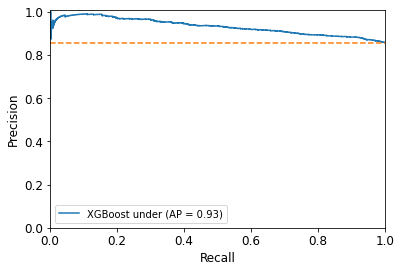

AUC_PRC : 0.93
AUC_ROC : 0.70
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.22      0.69      0.59      0.34      0.64      0.42       494
  Resistant       0.92      0.59      0.69      0.72      0.64      0.41      2957

avg / total       0.82      0.61      0.68      0.67      0.64      0.41      3451

>>>>>>>MEROPENEM<<<<<<<
Counter({1.0: 11242, 0.0: 1912})
SMOTEunder sampling
SMOTEunder Logistic Regression 
Counter({1.0: 11242, 0.0: 5621})


<Figure size 432x288 with 0 Axes>

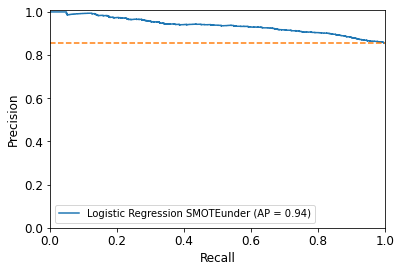

AUC_PRC : 0.94
AUC_ROC : 0.72
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.33      0.33      0.89      0.33      0.54      0.28       478
  Resistant       0.89      0.89      0.33      0.89      0.54      0.31      2811

avg / total       0.81      0.80      0.41      0.80      0.54      0.30      3289

SMOTEunder Decision Tree 
Counter({1.0: 11242, 0.0: 5621})


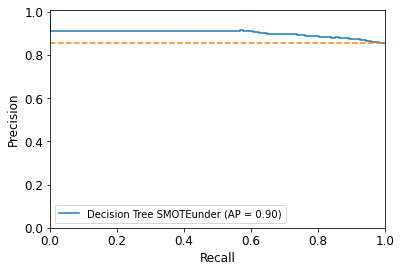

AUC_PRC : 0.93
AUC_ROC : 0.65
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.28      0.32      0.86      0.30      0.52      0.26       478
  Resistant       0.88      0.86      0.32      0.87      0.52      0.29      2811

avg / total       0.79      0.78      0.40      0.79      0.52      0.28      3289

SMOTEunder Random Forest 
Counter({1.0: 11242, 0.0: 5621})


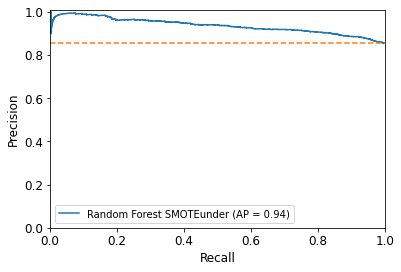

AUC_PRC : 0.94
AUC_ROC : 0.73
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.40      0.23      0.94      0.29      0.47      0.20       478
  Resistant       0.88      0.94      0.23      0.91      0.47      0.23      2811

avg / total       0.81      0.84      0.34      0.82      0.47      0.23      3289

SMOTEunder XGBoost 
Counter({1.0: 11242, 0.0: 5621})


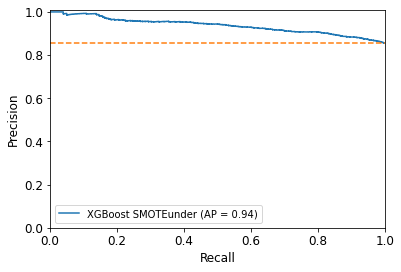

AUC_PRC : 0.94
AUC_ROC : 0.73
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.41      0.13      0.97      0.20      0.36      0.12       478
  Resistant       0.87      0.97      0.13      0.91      0.36      0.14      2811

avg / total       0.80      0.85      0.25      0.81      0.36      0.14      3289

SMOTE sampling
SMOTE Logistic Regression 
Counter({1.0: 11242, 0.0: 11242})


<Figure size 432x288 with 0 Axes>

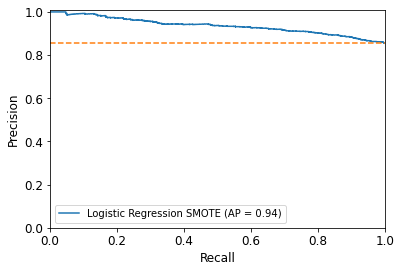

AUC_PRC : 0.94
AUC_ROC : 0.72
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.24      0.72      0.61      0.36      0.66      0.44       478
  Resistant       0.93      0.61      0.72      0.73      0.66      0.43      2811

avg / total       0.83      0.62      0.70      0.68      0.66      0.43      3289

SMOTE Decision Tree 
Counter({1.0: 11242, 0.0: 11242})


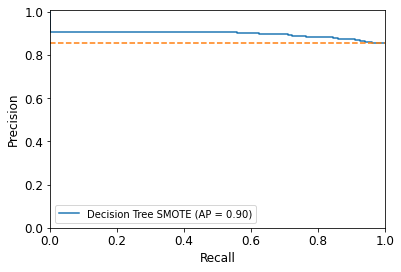

AUC_PRC : 0.92
AUC_ROC : 0.64
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.26      0.37      0.82      0.30      0.55      0.29       478
  Resistant       0.88      0.82      0.37      0.85      0.55      0.32      2811

avg / total       0.79      0.75      0.43      0.77      0.55      0.31      3289

SMOTE Random Forest 
Counter({1.0: 11242, 0.0: 11242})


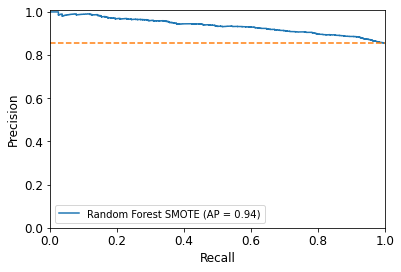

AUC_PRC : 0.94
AUC_ROC : 0.72
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.28      0.54      0.76      0.37      0.64      0.40       478
  Resistant       0.91      0.76      0.54      0.83      0.64      0.42      2811

avg / total       0.82      0.73      0.57      0.76      0.64      0.42      3289

SMOTE XGBoost 
Counter({1.0: 11242, 0.0: 11242})


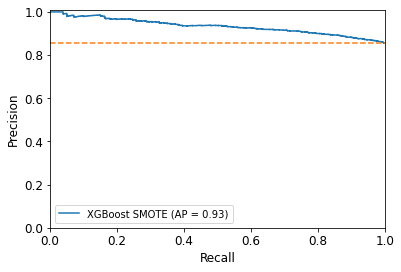

AUC_PRC : 0.93
AUC_ROC : 0.72
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.36      0.21      0.94      0.26      0.44      0.18       478
  Resistant       0.87      0.94      0.21      0.90      0.44      0.21      2811

avg / total       0.80      0.83      0.31      0.81      0.44      0.20      3289

normal sampling
normal Logistic Regression 
Counter({1.0: 11242, 0.0: 1912})


<Figure size 432x288 with 0 Axes>

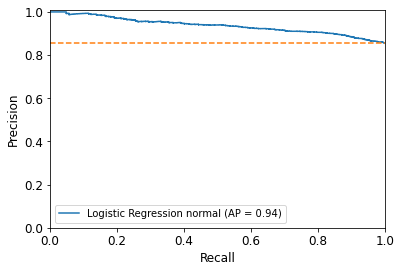

AUC_PRC : 0.94
AUC_ROC : 0.72
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.75      0.01      1.00      0.02      0.11      0.01       478
  Resistant       0.86      1.00      0.01      0.92      0.11      0.01      2811

avg / total       0.84      0.86      0.16      0.79      0.11      0.01      3289

normal Decision Tree 
Counter({1.0: 11242, 0.0: 1912})


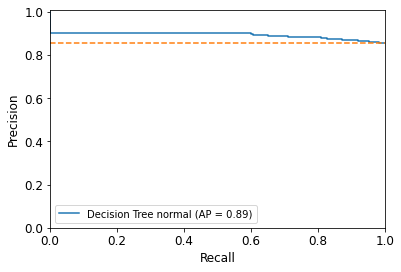

AUC_PRC : 0.92
AUC_ROC : 0.62
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.28      0.19      0.92      0.23      0.42      0.16       478
  Resistant       0.87      0.92      0.19      0.89      0.42      0.19      2811

avg / total       0.78      0.81      0.29      0.80      0.42      0.18      3289

normal Random Forest 
Counter({1.0: 11242, 0.0: 1912})


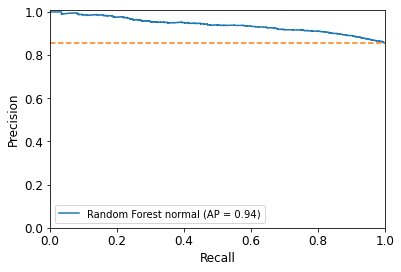

AUC_PRC : 0.94
AUC_ROC : 0.74
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.00      0.00      1.00      0.00      0.00      0.00       478
  Resistant       0.85      1.00      0.00      0.92      0.00      0.00      2811

avg / total       0.73      0.85      0.15      0.79      0.00      0.00      3289

normal XGBoost 
Counter({1.0: 11242, 0.0: 1912})


d:\Anaconda\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


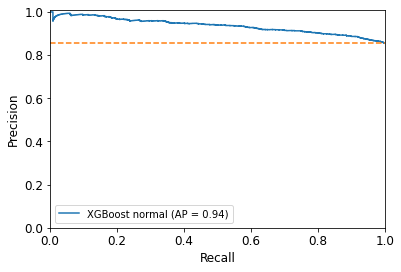

AUC_PRC : 0.94
AUC_ROC : 0.73
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.47      0.09      0.98      0.16      0.30      0.08       478
  Resistant       0.86      0.98      0.09      0.92      0.30      0.10      2811

avg / total       0.81      0.85      0.22      0.81      0.30      0.10      3289

over sampling
over Logistic Regression 
Counter({1.0: 11242, 0.0: 11242})


<Figure size 432x288 with 0 Axes>

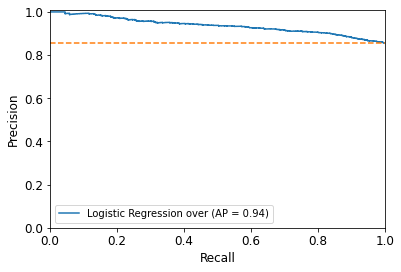

AUC_PRC : 0.94
AUC_ROC : 0.72
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.24      0.71      0.61      0.36      0.66      0.44       478
  Resistant       0.93      0.61      0.71      0.74      0.66      0.43      2811

avg / total       0.83      0.63      0.70      0.68      0.66      0.43      3289

over Decision Tree 
Counter({1.0: 11242, 0.0: 11242})


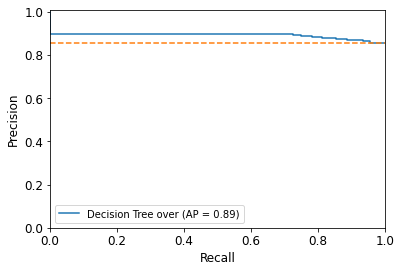

AUC_PRC : 0.93
AUC_ROC : 0.62
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.24      0.46      0.75      0.32      0.59      0.34       478
  Resistant       0.89      0.75      0.46      0.81      0.59      0.36      2811

avg / total       0.80      0.71      0.50      0.74      0.59      0.35      3289

over Random Forest 
Counter({1.0: 11242, 0.0: 11242})


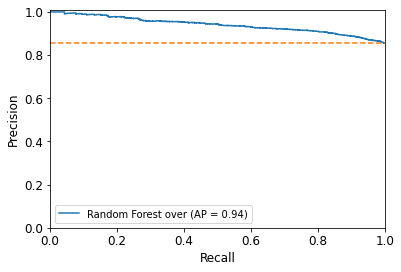

AUC_PRC : 0.94
AUC_ROC : 0.74
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.27      0.65      0.70      0.38      0.67      0.45       478
  Resistant       0.92      0.70      0.65      0.79      0.67      0.46      2811

avg / total       0.83      0.69      0.66      0.73      0.67      0.45      3289

over XGBoost 
Counter({1.0: 11242, 0.0: 11242})


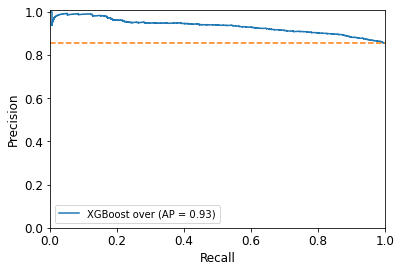

AUC_PRC : 0.93
AUC_ROC : 0.72
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.28      0.55      0.77      0.37      0.65      0.41       478
  Resistant       0.91      0.77      0.55      0.83      0.65      0.43      2811

avg / total       0.82      0.73      0.58      0.76      0.65      0.42      3289

under sampling
under Logistic Regression 
Counter({0.0: 1912, 1.0: 1912})


<Figure size 432x288 with 0 Axes>

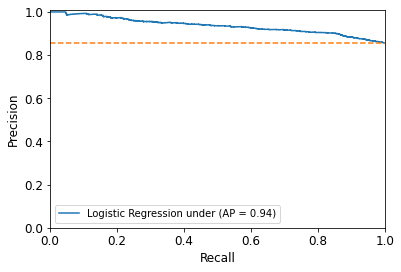

AUC_PRC : 0.94
AUC_ROC : 0.72
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.24      0.70      0.62      0.35      0.66      0.43       478
  Resistant       0.92      0.62      0.70      0.74      0.66      0.43      2811

avg / total       0.82      0.63      0.69      0.68      0.66      0.43      3289

under Decision Tree 
Counter({0.0: 1912, 1.0: 1912})


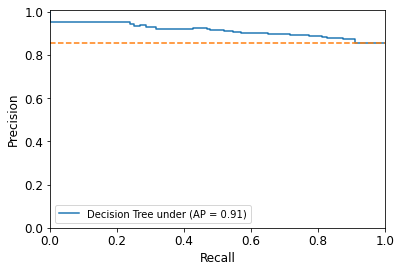

AUC_PRC : 0.92
AUC_ROC : 0.67
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.21      0.66      0.57      0.31      0.61      0.38       478
  Resistant       0.91      0.57      0.66      0.70      0.61      0.37      2811

avg / total       0.81      0.58      0.64      0.64      0.61      0.37      3289

under Random Forest 
Counter({0.0: 1912, 1.0: 1912})


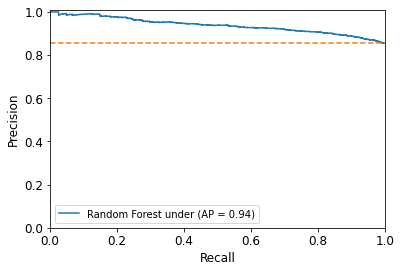

AUC_PRC : 0.94
AUC_ROC : 0.73
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.24      0.71      0.63      0.36      0.67      0.45       478
  Resistant       0.93      0.63      0.71      0.75      0.67      0.44      2811

avg / total       0.83      0.64      0.70      0.69      0.67      0.44      3289

under XGBoost 
Counter({0.0: 1912, 1.0: 1912})


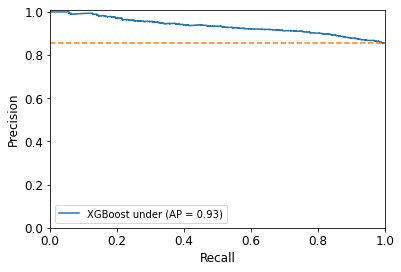

AUC_PRC : 0.93
AUC_ROC : 0.71
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.24      0.67      0.63      0.35      0.65      0.43       478
  Resistant       0.92      0.63      0.67      0.75      0.65      0.42      2811

avg / total       0.82      0.64      0.67      0.69      0.65      0.43      3289

>>>>>>>VANCOMYCIN<<<<<<<
Counter({1.0: 1664, 0.0: 242})
SMOTEunder sampling
SMOTEunder Logistic Regression 
Counter({1.0: 1664, 0.0: 832})


<Figure size 432x288 with 0 Axes>

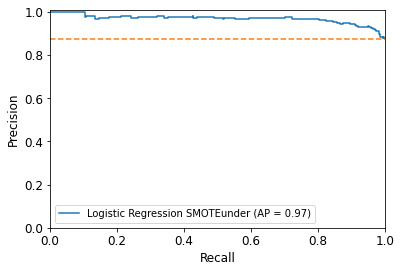

AUC_PRC : 0.97
AUC_ROC : 0.85
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.45      0.66      0.88      0.53      0.76      0.57        61
  Resistant       0.95      0.88      0.66      0.91      0.76      0.59       416

avg / total       0.88      0.85      0.68      0.86      0.76      0.59       477

SMOTEunder Decision Tree 
Counter({1.0: 1664, 0.0: 832})


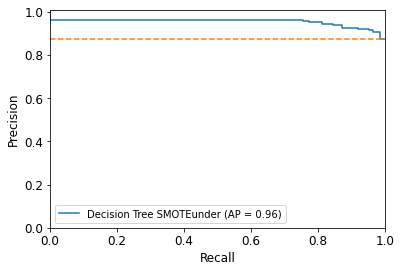

AUC_PRC : 0.97
AUC_ROC : 0.82
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.48      0.49      0.92      0.48      0.67      0.43        61
  Resistant       0.93      0.92      0.49      0.92      0.67      0.47       416

avg / total       0.87      0.87      0.55      0.87      0.67      0.47       477

SMOTEunder Random Forest 
Counter({1.0: 1664, 0.0: 832})


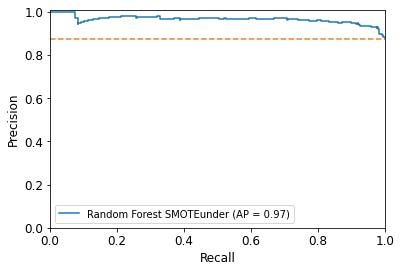

AUC_PRC : 0.97
AUC_ROC : 0.85
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.60      0.54      0.95      0.57      0.72      0.49        61
  Resistant       0.93      0.95      0.54      0.94      0.72      0.53       416

avg / total       0.89      0.90      0.59      0.89      0.72      0.53       477

SMOTEunder XGBoost 
Counter({1.0: 1664, 0.0: 832})


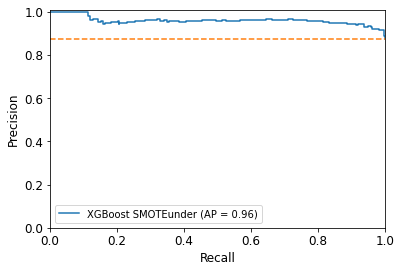

AUC_PRC : 0.96
AUC_ROC : 0.83
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.63      0.51      0.96      0.56      0.70      0.46        61
  Resistant       0.93      0.96      0.51      0.94      0.70      0.51       416

avg / total       0.89      0.90      0.57      0.89      0.70      0.50       477

SMOTE sampling
SMOTE Logistic Regression 
Counter({1.0: 1664, 0.0: 1664})


<Figure size 432x288 with 0 Axes>

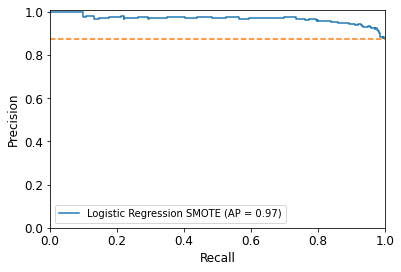

AUC_PRC : 0.97
AUC_ROC : 0.85
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.37      0.75      0.81      0.50      0.78      0.61        61
  Resistant       0.96      0.81      0.75      0.88      0.78      0.62       416

avg / total       0.88      0.81      0.76      0.83      0.78      0.62       477

SMOTE Decision Tree 
Counter({1.0: 1664, 0.0: 1664})


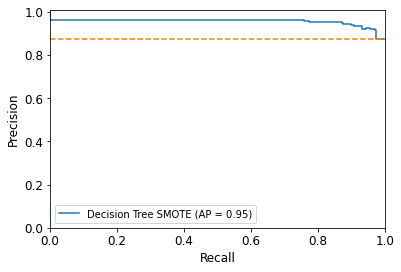

AUC_PRC : 0.97
AUC_ROC : 0.82
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.47      0.61      0.90      0.53      0.74      0.53        61
  Resistant       0.94      0.90      0.61      0.92      0.74      0.56       416

avg / total       0.88      0.86      0.64      0.87      0.74      0.56       477

SMOTE Random Forest 
Counter({1.0: 1664, 0.0: 1664})


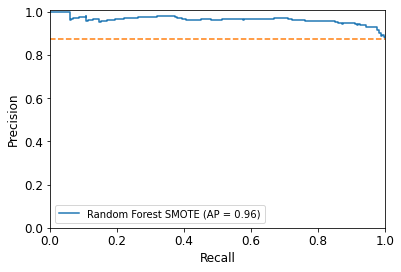

AUC_PRC : 0.96
AUC_ROC : 0.84
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.43      0.66      0.87      0.52      0.76      0.56        61
  Resistant       0.95      0.87      0.66      0.91      0.76      0.58       416

avg / total       0.88      0.84      0.68      0.86      0.76      0.58       477

SMOTE XGBoost 
Counter({1.0: 1664, 0.0: 1664})


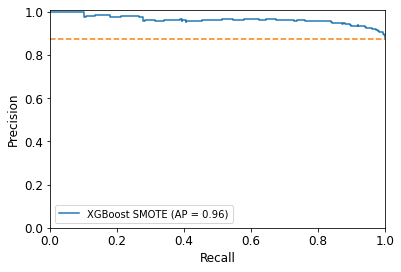

AUC_PRC : 0.96
AUC_ROC : 0.83
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.57      0.51      0.94      0.54      0.69      0.46        61
  Resistant       0.93      0.94      0.51      0.94      0.69      0.50       416

avg / total       0.88      0.89      0.56      0.89      0.69      0.50       477

normal sampling
normal Logistic Regression 
Counter({1.0: 1664, 0.0: 242})


<Figure size 432x288 with 0 Axes>

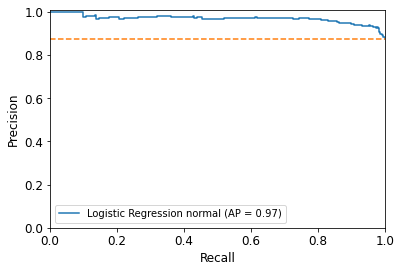

AUC_PRC : 0.97
AUC_ROC : 0.86
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.76      0.36      0.98      0.49      0.60      0.33        61
  Resistant       0.91      0.98      0.36      0.95      0.60      0.38       416

avg / total       0.89      0.90      0.44      0.89      0.60      0.37       477

normal Decision Tree 
Counter({1.0: 1664, 0.0: 242})


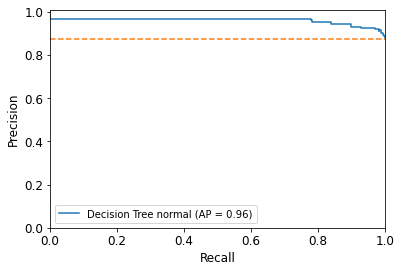

AUC_PRC : 0.97
AUC_ROC : 0.84
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.67      0.43      0.97      0.52      0.64      0.39        61
  Resistant       0.92      0.97      0.43      0.94      0.64      0.44       416

avg / total       0.89      0.90      0.50      0.89      0.64      0.43       477

normal Random Forest 
Counter({1.0: 1664, 0.0: 242})


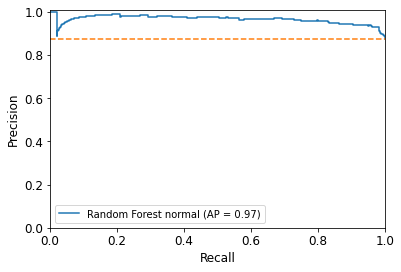

AUC_PRC : 0.97
AUC_ROC : 0.85
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       1.00      0.15      1.00      0.26      0.38      0.13        61
  Resistant       0.89      1.00      0.15      0.94      0.38      0.16       416

avg / total       0.90      0.89      0.26      0.85      0.38      0.16       477

normal XGBoost 
Counter({1.0: 1664, 0.0: 242})


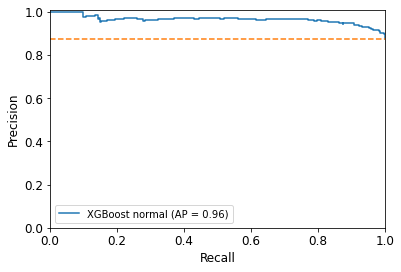

AUC_PRC : 0.96
AUC_ROC : 0.84
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.62      0.43      0.96      0.50      0.64      0.39        61
  Resistant       0.92      0.96      0.43      0.94      0.64      0.43       416

avg / total       0.88      0.89      0.49      0.88      0.64      0.43       477

over sampling
over Logistic Regression 
Counter({1.0: 1664, 0.0: 1664})


<Figure size 432x288 with 0 Axes>

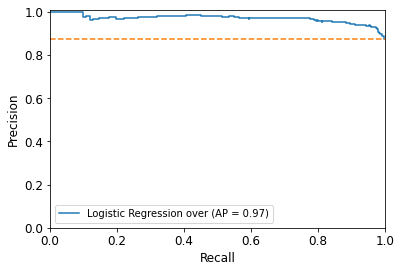

AUC_PRC : 0.97
AUC_ROC : 0.86
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.36      0.75      0.80      0.48      0.78      0.60        61
  Resistant       0.96      0.80      0.75      0.87      0.78      0.61       416

avg / total       0.88      0.79      0.76      0.82      0.78      0.61       477

over Decision Tree 
Counter({1.0: 1664, 0.0: 1664})


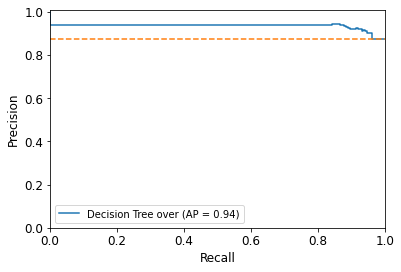

AUC_PRC : 0.96
AUC_ROC : 0.75
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.41      0.64      0.87      0.50      0.74      0.54        61
  Resistant       0.94      0.87      0.64      0.90      0.74      0.57       416

avg / total       0.87      0.84      0.67      0.85      0.74      0.56       477

over Random Forest 
Counter({1.0: 1664, 0.0: 1664})


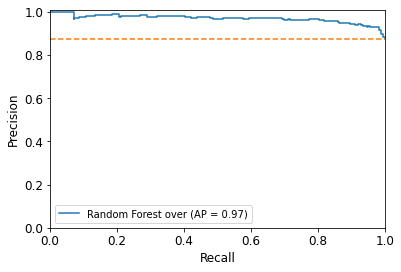

AUC_PRC : 0.97
AUC_ROC : 0.86
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.37      0.80      0.80      0.51      0.80      0.64        61
  Resistant       0.97      0.80      0.80      0.88      0.80      0.64       416

avg / total       0.89      0.80      0.80      0.83      0.80      0.64       477

over XGBoost 
Counter({1.0: 1664, 0.0: 1664})


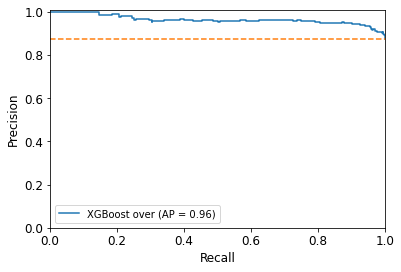

AUC_PRC : 0.96
AUC_ROC : 0.83
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.56      0.57      0.94      0.57      0.73      0.52        61
  Resistant       0.94      0.94      0.57      0.94      0.73      0.56       416

avg / total       0.89      0.89      0.62      0.89      0.73      0.55       477

under sampling
under Logistic Regression 
Counter({0.0: 242, 1.0: 242})


<Figure size 432x288 with 0 Axes>

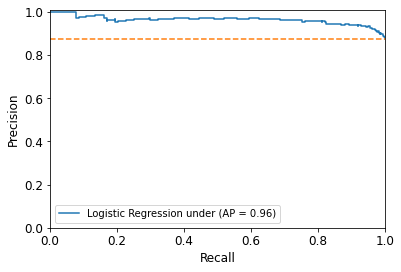

AUC_PRC : 0.96
AUC_ROC : 0.83
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.31      0.77      0.75      0.45      0.76      0.58        61
  Resistant       0.96      0.75      0.77      0.84      0.76      0.58       416

avg / total       0.87      0.75      0.77      0.79      0.76      0.58       477

under Decision Tree 
Counter({0.0: 242, 1.0: 242})


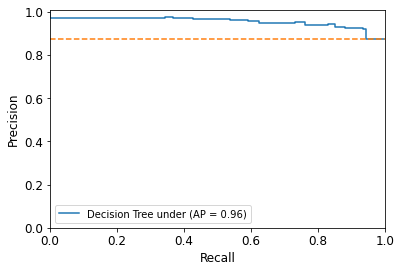

AUC_PRC : 0.96
AUC_ROC : 0.81
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.26      0.74      0.69      0.38      0.71      0.51        61
  Resistant       0.95      0.69      0.74      0.80      0.71      0.51       416

avg / total       0.86      0.70      0.73      0.75      0.71      0.51       477

under Random Forest 
Counter({0.0: 242, 1.0: 242})


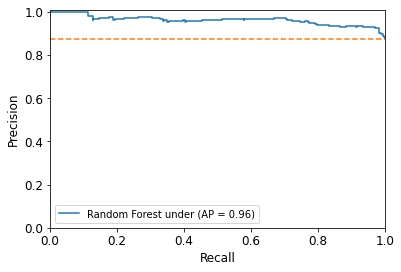

AUC_PRC : 0.96
AUC_ROC : 0.82
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.32      0.74      0.77      0.45      0.75      0.57        61
  Resistant       0.95      0.77      0.74      0.85      0.75      0.57       416

avg / total       0.87      0.77      0.74      0.80      0.75      0.57       477

under XGBoost 
Counter({0.0: 242, 1.0: 242})


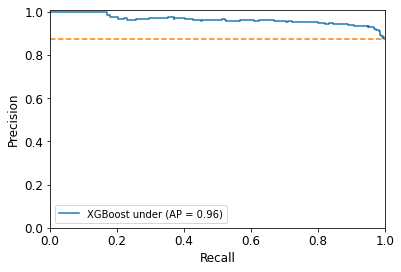

AUC_PRC : 0.96
AUC_ROC : 0.83
                   pre       rec       spe        f1       geo       iba       sup

  Sensitive       0.32      0.74      0.77      0.45      0.76      0.57        61
  Resistant       0.95      0.77      0.74      0.85      0.76      0.57       416

avg / total       0.87      0.77      0.74      0.80      0.76      0.57       477



In [7]:
#Main context
model_name = ['Logistic Regression ',
              #'SVM ',
              'Decision Tree ',
              'Random Forest ',
              'XGBoost '
              ]
sampling_method=['SMOTEunder','SMOTE','normal','over','under']
#Antibiotics=['AMIKACIN','CEFOXITIN','CEFTAZIDIME','LEVOFLOXACIN','MEROPENEM','PIP_TAZO','VANCOMYCIN']
Antibiotics=['CEFTAZIDIME','MEROPENEM','VANCOMYCIN']
#bacteriagroup=['Acinetobacter spp.','Escherichia coli','Klebsiella spp.','Staphylococcus spp.','Pseudomonas aeruginosa']
bacteriagroup=['Escherichia coli ','Klebsiella spp.','Staphylococcus spp.','Pseudomonas aeruginosa']
#bacteria='Escherichia coli'
#This code below doesnt cluster bacteria group
#for bacteria in bacteriagroup:
#    Antibiotic='AMIKACIN'
#    print('=========='+str(bacteria).upper()+'==========')
for Antibiotic in Antibiotics:
    print('>>>>>>>'+str(Antibiotic).upper()+'<<<<<<<')
    #clean_X,clean_Y=GetData(Antibiotic,bacteria)
    clean_X,clean_Y=GetDataNoGroup(Antibiotic)
    if (len(clean_Y)<50 ) or (len(clean_Y)-np.sum(clean_Y)<=50):
        print('Not engough data <50')
        continue
    x_train_std,x_test_std,y_train,y_test=StratSampling(clean_X,clean_Y)
    print(Counter(y_train))
    Train(x_train_std,x_test_std,y_train,y_test)
